In [41]:
import os
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from typing import List
from torch import Tensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor


In [42]:
from dataclasses import dataclass, field

@dataclass
class Config:
    PLAYERS_SIZE: int = 0
    CONTEXT_LEN: int = 16  ## predict the 21st match by the 20
    PERFORMANCE_INPUT_DIM = 23
    PERFORMANCE_EMBD_DIM: int = 128
    
    PLAYER_INPUT_DIM: int = 25   ## univpalyer
    MATCH_INPUT_EMBD: int = 14   ## match_info
    NUM_EPOCHS: int = 100
    LEARNING_RATE: float = 1e-3
    BATCH_SIZE: int = 32
    DEVICE: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")
    # MODEL_SAVE_PATH: str = "/kaggle/working"
    # BASE_DIR: str = '/kaggle/input/flickr8k/'
    # CROSSATT_NUM_HEADS: int = 8
    CLS_INIT_STD: float = 0.02    ## <CLS> token initialized with std 0.02 from the mean=0
    TEST_DATASET_SIZE: int = 180
    IDLE_DEVICE: str = 'cpu'
    ACCUMULATION_STEPS = 4


In [43]:
config = Config()

## Defination of **Losses**

# Data

In [44]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class PlayerMatchDataset(Dataset):
    """
    Dataset for autoregressive next-match prediction.

    For each sample:
      1. Given a player_id, retrieve universal player features from universal_player.csv.
         (The 'player_id' and 'cricinfo_id' columns are dropped from the input features.)
      2. Retrieve all matches for that player from a directory of player match files
         (each file is named "{player_id}.csv" and contains the matches for that player,
         already sorted by date).
         The performance columns include:
           batting_position, runs, balls, fours, sixes, strike_rate, overs, total_balls, dots,
           maidens, conceded, fours_conceded, sixes_conceded, wickets, LBW, Bowled, noballs,
           wides, economy_rate, catches, stumping, direct_hit, indirect_hit, strike_rate_fp,
           batting_fp, bowling_fp, fielding_fp, total_fp.
         We drop 'match_id' and the fantasy-breakdown columns
         ('strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp') when forming the input vector.
      3. Randomly sample a contiguous window of (context_len + 1) matches for this player.
         The first context_len matches serve as input and matches 2 ... context_len+1 yield the target fantasy scores.
      4. For each match in the window:
         - Load the corresponding match players CSV from the match_players folder (file: '{match_id}.csv').
         - Determine the player's team for that match and then separate player_ids into:
              team1_ids: those belonging to the same team as the player,
              team2_ids: those belonging to the other team.
         - Retrieve their universal features from universal_player.csv.
         - Retrieve match info from a single match_info CSV (by matching on match_id).
      5. Return a dictionary containing:
         - 'player_id': the player's id.
         - 'univ_features': the player's universal features.
         - 'context_matches': a numpy array of performance features for the context matches.
         - 'target_scores': a numpy array of target fantasy scores (for matches 2 ... context_len+1).
         - 'team1_players': list (per match) of team1 players' universal features.
         - 'team2_players': list (per match) of team2 players' universal features.
         - 'match_info': list (per match) of match info dictionaries.
    """

    def __init__(self, universal_player_csv, player_matches_dir, match_players_dir, match_info_csv, context_len=25, transform=None):
        """
        Args:
            universal_player_csv (str): Path to universal_player.csv.
            player_matches_dir (str): Directory containing CSV files for each player's matches (named '{player_id}.csv').
            match_players_dir (str): Directory containing match_players CSV files.
            match_info_csv (str): Path to the CSV file containing match info for all matches.
            context_len (int): Number of context matches to use as input 
                                (target will be matches 2 ... context_len+1).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.context_len = context_len
        self.transform = transform

        # Load universal player features and set player_id as index.
        self.univ_df = pd.read_csv(universal_player_csv)
        self.univ_df = self.univ_df.set_index('player_id')
        # Drop 'cricinfo_id' as it is redundant.
        self.univ_features = self.univ_df.drop(columns=['cricinfo_id'], errors='ignore')

        # Instead of a single file for player matches, we assume a directory where each player's
        # matches are stored in a file named '{player_id}.csv'. We build a list of valid player_ids
        # by checking which player match files exist and ensuring they have at least (context_len+1) rows.
        self.player_matches_dir = player_matches_dir
        self.player_ids = []
        self.player_match_data = {}  # Key: player_id, Value: DataFrame of that player's matches.
        for player_id in self.univ_features.index:
            match_file = os.path.join(player_matches_dir, f"{player_id}.csv")
            if os.path.exists(match_file):
                df_matches = pd.read_csv(match_file)
                # Assume the matches in this file are already sorted by date.
                if len(df_matches) >= (self.context_len + 1):
                    self.player_ids.append(player_id)
                    self.player_match_data[player_id] = df_matches

        self.match_players_dir = match_players_dir

        # Load the single match_info CSV and set match_id as index for fast lookup.
        self.match_info_df = pd.read_csv(match_info_csv)
        self.match_info_df = self.match_info_df.set_index('match_id')
        # Optionally drop columns not needed.
        self.match_info_df = self.match_info_df.drop(columns=['team1', 'team2', 'toss_winner', "toss_decision", "winner"], errors='ignore')
        #Todo don't just drop them we need to infer from them in sense of player's team ->winner 1 else 0

    def __len__(self):
        return len(self.player_ids)

    def __getitem__(self, idx):
        """
        Returns a dictionary with:
          - 'player_id': the player's id.
          - 'univ_features': universal features for the player.
          - 'context_matches': a numpy array of performance features for the context matches.
          - 'target_scores': a numpy array of target fantasy scores (for matches 2 ... context_len+1).
          - 'team1_players': list (per match) of team1 players' universal features.
          - 'team2_players': list (per match) of team2 players' universal features.
          - 'match_info': list (per match) of match info dictionaries.
        """
        #ToDO not just total_fantasy score, rather a weighted sum of error for batting_bowling fp's, fielding_fp with lesser weightage to the overall total_fp  
        # Select the player.
        player_id = self.player_ids[idx]
        # Retrieve the player's universal features as a numpy array.
        player_univ = self.univ_features.loc[player_id].values.astype(float)
        
        # Load this player's matches DataFrame from the pre-loaded dictionary.
        df_matches = self.player_match_data[player_id]
        total_matches = len(df_matches)
        # Randomly select a contiguous window of (context_len + 1) matches.
        start_idx = np.random.randint(1, total_matches - self.context_len+1)
        window_df = df_matches.iloc[start_idx-1 : start_idx + self.context_len]

        # For input, drop the unused columns.
        exclude_cols = ['teamname', 'match_id',
                        'strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp']
        # Extract target fantasy scores (from column 'total_fp') for matches 2 ... context_len+1.
        target_scores = window_df.iloc[1:self.context_len+1][['batting_fp', 'bowling_fp', 'fielding_fp',]].values.astype(float)
        #Todo account for all sub_fp's (stage -2)
        # Extract performance features for input matches.
        context_matches = window_df.iloc[:self.context_len].drop(columns=exclude_cols, errors='ignore')

        # For each match in the window, retrieve team players and match info.
        # team1_players_list = [] 
        team2_players_list = []
        match_info_list = []
        for _, match in window_df.iterrows():
            match_id = match['match_id']
            # Load match players file (expects a file named "{match_id}.csv").
            match_players_file = os.path.join(self.match_players_dir, f"{int(match_id)}.csv")
            match_players_df = pd.read_csv(match_players_file)
            
            # Determine the team of the sample's player in this match.
            player_team_series = match_players_df[
                match_players_df['player_id'] == player_id]['Team']
            #? rather we can refer it from window_df, there in the excluded_cols same as match['team_name']
            if not player_team_series.empty:
                player_team = player_team_series.iloc[0]
            else:
                player_team = match_players_df.iloc[0]['Team'] #?why's this, though it won't execute
            
            # Split player_ids into two groups based on the player's team.
            # team1_ids = match_players_df[
            #     match_players_df['Team'] == player_team]['player_id'].tolist()
            # #! we just need the team2 player_ids (we are omitting the intra-team interactions...)
            team2_ids = match_players_df[
                match_players_df['Team'] != player_team]['player_id'].tolist()

            # Retrieve universal features for these players.
            # team1_features = self.univ_features.reindex(team1_ids).dropna().values.astype(float)
            team2_features = self.univ_features.reindex(team2_ids).dropna().values.astype(float)
            # team1_players_list.append(team1_features)
            team2_players_list.append(team2_features)
            
            # Retrieve match info using match_id from the single match_info DataFrame.
            if match_id in self.match_info_df.index:
                match_info_dict = self.match_info_df.loc[match_id].to_dict()
            else:
                match_info_dict = { }
            match_info_list.append(match_info_dict)
            #? wht's this 

        # --- START OF CHANGES: convert to properly shaped torch.Tensors ---
        import torch

        # universal features
        univ_features = torch.tensor(player_univ, dtype=torch.float32)  # (feat_dim,)

        # context matches
        context_matches = torch.tensor(context_matches.values.astype(float),
                                       dtype=torch.float32)  # (context_len, perf_dim)

        # target scores
        target_scores = torch.tensor(target_scores, dtype=torch.float32)  # (context_len,)

        # team1 players: pad to max players across the window, then stack
        # max1 = max(arr.shape[0] for arr in team1_players_list)
        # feat_dim = team1_players_list[0].shape[1] if max1>0 else 0
        # padded1 = [
        #     np.pad(arr, ((0, max1 - arr.shape[0]), (0, 0)), mode='constant')
        #     for arr in team1_players_list
        # ]
        # team1_players = torch.tensor(np.stack(padded1), dtype=torch.float32)
        # # shape: (context_len+1, max1, feat_dim)

        # team2 players: same
        max2 = max(arr.shape[0] for arr in team2_players_list)
        feat_dim2 = team2_players_list[0].shape[1] if max2>0 else 0
        padded2 = [
            np.pad(arr, ((0, max2 - arr.shape[0]), (0, 0)), mode='constant')
            for arr in team2_players_list
        ]
        team2_players = torch.tensor(np.stack(padded2), dtype=torch.float32)
        # shape: (context_len+1, max2, feat_dim2)
        #? wht's this

        # match_info: convert list of dicts to array in fixed key order
        keys = list(self.match_info_df.columns)
        info_arr = np.stack([[d.get(k, 0.0) for k in keys] for d in match_info_list])
        match_info = torch.tensor(info_arr, dtype=torch.float32)
        # shape: (context_len+1, len(keys))

        # --- END OF CHANGES ---

        sample = {
            'player_id': player_id,
            'univ_features': univ_features,
            'context_matches': context_matches,
            'target_scores': target_scores,
            # 'team1_players': team1_players[:, :11, :],
            'team2_players': team2_players[:, :11, :],
            'match_info': match_info
        }
        
        if self.transform:
            sample = self.transform(sample)
        return sample


In [45]:
import os
from torch.utils.data import DataLoader

# Define file paths (update these paths as needed for your folder structure)
universal_player_csv = r'C:\Users\kumar\IPL_Fantasy_Score_Prediction\Ashu\Test_1\cleaned_universal_player.csv'
player_matches_dir = r'C:\Users\kumar\IPL_Fantasy_Score_Prediction\Ashu\Test_1\Processed_Player_records'  # Contains files named like {player_id}.csv (each containing that player's matches)
match_players_dir = r'C:\Users\kumar\IPL_Fantasy_Score_Prediction\Ashu\Test_1\processed_GlobalMatchrecords'    # Contains files like {match_id}.csv
match_info_csv = r'C:\Users\kumar\IPL_Fantasy_Score_Prediction\Ashu\Test_1\cleaned_matchinfo_without_venue_with_updated_match_number.csv'               # Single CSV containing all match info

# Define the context length (number of matches to use as context)
# For example, if config.CONTEXT_LEN is defined in your config module:
# config.CONTEXT_LEN = 5

# Initialize the dataset
dataset = PlayerMatchDataset(
    universal_player_csv=universal_player_csv,
    player_matches_dir=player_matches_dir,  # This parameter may be ignored if you use the directory version
    match_players_dir=match_players_dir,
    match_info_csv=match_info_csv,
    context_len=config.CONTEXT_LEN
)

# def get_shape(lst):
#     shape = []
#     while isinstance(lst, list):
#         shape.append(len(lst))
#         if len(lst) == 0:
#             break
#         lst = lst[0]
#     return tuple(shape)



# Initialize the DataLoader
# dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
len(dataset)



2354

In [46]:
dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
for batch in dataloader:
    print("Player IDs:", batch['player_id'])  # list of player_ids (length = batch_size)
    
    print("Universal features shape:", (batch['univ_features']).shape)  # e.g., (batch_size, num_features)
    
    print("Context matches shape:", batch['context_matches'].shape)  # e.g., (batch_size, context_len, performance_feature_dim)
    
    print("Target scores shape:", batch['target_scores'].shape)      # e.g., (batch_size, context_len)
    
    # The following are lists of length (context_len+1); each element is a numpy array.
    # team1_players_tensor = list_of_tensors_to_3d(batch['team1_players'])
    # team1_players_tensor = team1_players_tensor.squeeze(2)
    # print("Number of matches in team1_players (per sample):", batch['team1_players'].shape)
    
    # team2_players_tensor = list_of_tensors_to_3d(batch['team2_players'])
    # team2_players_tensor = team2_players_tensor.squeeze(2)
    print("Number of matches in team2_players (per sample):", batch['team2_players'].shape)
    
    # match_info_tensor = list_of_dicts_to_tensor(batch['match_info'])
    print("Number of matches in match_info (per sample):", (batch['match_info']).shape)
    break

Player IDs: ['7671203a', 'eee46f77', '0c7f11be', '10b79140', 'e855546b', '4531f249', 'aaa1b522', 'dadbdb68', 'd18d3a0f', 'bf2d865c', '7081848a', '60938c83', '84dc72db', '51e1ed69', '7ba6ef29', '2ae01eb0', '2a9eee66', '34dd3fd9', '0d0f0385', 'e6e9b619', '39ed0d2f', '1fc6ef83', 'bf6e03ea', '1a628a92', 'cfe70281', 'fb0abc20', '0b581ed6', '725529bc', 'f2c936d7', 'ce820073', '2494ff9e', 'ae091d39']
Universal features shape: torch.Size([32, 25])
Context matches shape: torch.Size([32, 16, 23])
Target scores shape: torch.Size([32, 16, 3])
Number of matches in team2_players (per sample): torch.Size([32, 17, 11, 25])
Number of matches in match_info (per sample): torch.Size([32, 17, 14])


In [47]:
def list_of_tensors_to_3d(tensor_list):
    """
    Converts a list of tensors into a 3D tensor with shape:
    (1, number_of_tensors, *inner_tensor_shape)
    
    Args:
        tensor_list (list of torch.Tensor): List of tensors with identical shapes.
        
    Returns:
        torch.Tensor: A tensor with the new shape (1, len(tensor_list), inner dims...).
    """
    # First stack the tensors along dimension 0: shape becomes (number_of_tensors, inner dims...)
    stacked = torch.stack(tensor_list, dim=0)
    # Add a leading dimension to obtain the final shape (1, number_of_tensors, inner dims...)
    return stacked.unsqueeze(0)


def list_of_dicts_to_tensor(data, key_order=None):
    """
    Convert a list of dictionaries (each with tensor or numeric values) 
    into a 3D tensor of shape (1, number_of_dicts, number_of_keys).

    Args:
        data (list): List of dictionaries where each dictionary contains the same keys.
        key_order (list, optional): Specific order of keys to extract from each dictionary.
                                    If None, keys from the first dictionary are used.

    Returns:
        torch.Tensor: A 3D tensor with shape (1, len(data), len(key_order)).
    """
    if not data:
        raise ValueError("The input data list is empty.")
    
    # Use keys from the first dictionary if no order is specified.
    if key_order is None:
        key_order = list(data[0].keys())
    
    values_list = []
    for d in data:
        # Extract values in the specified order. Convert tensor values to scalar if necessary.
        values = []
        for key in key_order:
            value = d[key]
            if isinstance(value, torch.Tensor):
                # Assuming tensor is of shape (1,)
                values.append(value.item())
            else:
                values.append(value)
        values_list.append(values)
    
    # Convert the list of lists to a 2D tensor.
    tensor_2d = torch.tensor(values_list)
    # Add a new dimension at the beginning to make it 3D.
    tensor_3d = tensor_2d.unsqueeze(0)
    return tensor_3d

## MODEL **Architechure**

In [48]:
class PlayerEmbedding(nn.Module):
  """ HEre we are doing the Proj of the raw Player embedding into the PERFORMANCE_EMBD_DIM """
  def __init__(self, in_channels=config.PLAYER_INPUT_DIM, out_channels=config.PERFORMANCE_EMBD_DIM):
    super().__init__()
    self.proj = nn.Linear(in_channels, out_channels)

  def forward(self, x):
    # print(f"In Player Embd  {x.shape}")
    # x: (B, PLAYER_INPUT_DIM) or flattened (B*T, PLAYER_INPUT_DIM)
    return self.proj(x)   ## ( B/B*T, PERFORMANCE_EMBD)

In [49]:
# class CrossAttention(nn.Module):
#     def __init__(self, d_embed=config.PERFORMANCE_EMBD_DIM, d_cross=config.PERFORMANCE_EMBD_DIM, n_heads=8, in_proj_bias=True, out_proj_bias=True):
#         super().__init__()
#         # Initialize linear layers for query, key, and value projections.
#         # q_proj: projects the query input with shape (batch_size, seq_length_q=1, d_embed)
#         self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
#         # k_proj: projects the key input with shape (batch_size, seq_length_kv=11, d_cross)
#         self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
#         # v_proj: projects the value input with shape (batch_size, seq_length_kv=11, d_cross)
#         self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
#         # out_proj: projects the concatenated multi-head outputs back to the original embedding dimension.
#         self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
#         self.n_heads = n_heads                     # Number of attention heads.
#         self.d_head = d_embed // n_heads           # Dimensionality per head.

#     def forward(self, x, y):
#         """
#         Compute cross-attention between two sequences.

#         Parameters:
#             x (Tensor): Query input tensor of shape (batch_size, seq_length_q=1, d_embed)
#             y (Tensor): Key/Value input tensor of shape (batch_size, seq_length_kv=11, d_cross)

#         Returns:
#             Tensor: Output tensor after applying cross-attention, with shape (batch_size, seq_length_q=1, d_embed)
#         """
#         # Save original input shape.
#         input_shape = x.shape  # (batch_size, seq_length_q=1, d_embed)
#         batch_size, sequence_length, d_embed = input_shape

#         # Define intermediate shape for splitting into multiple heads.
#         # New shape: (batch_size, seq_length, n_heads, d_head)
#         interim_shape = (batch_size, -1, self.n_heads, self.d_head)

#         # Apply linear projections:
#         # q: project queries from x.
#         q = self.q_proj(x)  # (batch_size, seq_length_q=1, d_embed)
#         # k: project keys from y.
#         k = self.k_proj(y)  # (batch_size, seq_length_kv=11, d_embed)
#         # v: project values from y.
#         v = self.v_proj(y)  # (batch_size, seq_length_kv=11, d_embed)

#         # Reshape projections to separate attention heads.
#         # Transform shape to (batch_size, n_heads, seq_length, d_head)
#         q = q.view(interim_shape).transpose(1, 2)
#         k = k.view(interim_shape).transpose(1, 2)
#         v = v.view(interim_shape).transpose(1, 2)

#         # Compute attention scores using scaled dot-product:
#         # Multiply queries with transposed keys.
#         # Resulting shape: (batch_size, n_heads, seq_length_q=1, seq_length_kv=11)
#         weight = q @ k.transpose(-1, -2)

#         # Scale the scores by the square root of head dimension to stabilize gradients.
#         weight /= math.sqrt(self.d_head)

#         # Normalize the attention weights using softmax along the key dimension.
#         weight = F.softmax(weight, dim=-1)

#         # Compute the weighted sum over the values.
#         # Output shape: (batch_size, n_heads, seq_length_q=1, d_head)
#         output = weight @ v

#         # Reorder dimensions to combine multiple heads:
#         # Transpose back to (batch_size, seq_length_q=1, n_heads, d_head) and make contiguous.
#         output = output.transpose(1, 2).contiguous()

#         # Merge the multi-head outputs to recover original embedding dimension.
#         # Final shape: (batch_size, seq_length_q=1, d_embed)
#         output = output.view(input_shape)

#         # Apply the final output projection.
#         output = self.out_proj(output)

#         return output  # Return the final cross-attention output.

# given this cross attention module, i want to apply to calculate the cross attention from team2 to team1 players embeddings...
# #! handle cross attention (also should it be applied using team2 and current player)
# class MatchEmbedding(nn.Module):
#     """
#     Computes a match-level embedding from team and match information.
#     performing cross attention from team_players performance -> current palyer performance 
#     Expected input shapes (for T matches):
#       team1_players: (B, T, num_team1, PLAYER_INPUT_DIM) #!TODO we are passing it
#       team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
#       #? TODO implement cross attention (including player X team-2 performance )
      
#       match_info: (B, T, match_info_dim)
#     Output:
#       (B, T, PERFORMANCE_EMBD_DIM)
#     """
#     def __init__(self, player_embedding_module, in_channels=(2*config.PERFORMANCE_EMBD_DIM + config.MATCH_INPUT_EMBD), out_channels=config.PERFORMANCE_EMBD_DIM):
#         super().__init__()
#         self.player = player_embedding_module
#         self.proj = nn.Linear(in_channels, out_channels)

#     def forward(self, team1_players, team2_players, match_info):
#         """
#           1. Get player embeddings using self.player.
#           2. Sum (or pool) embeddings for each team.
#           3. Concatenate team representations with match_info.
#           4. Project the concatenated vector to obtain the final match embedding.
#         """
#         B, T, num_team1, _ = team1_players.shape
#         # print(f"In match embd {team1_players.shape} & {match_info.shape}, B {B}, T, {T}, nums_team1 {num_team1}")
#         # Compute player embeddings
#         team1_flat = team1_players.reshape(B * T, num_team1, -1)  # (B*T, num_team1, PLAYER_INPUT_DIM)
#         team1_embeds = self.player(team1_flat)  # (B*T, num_team1, PERFORMANCE_EMBD_DIM)
#         team1_sum = team1_embeds.sum(dim=1)  # (B*T, PERFORMANCE_EMBD_DIM)
#         team1_sum = team1_sum.reshape(B, T, -1)  # (B, T, PERFORMANCE_EMBD_DIM)

#         B, T, num_team2, _ = team2_players.shape
#         team2_flat = team2_players.reshape(B * T, num_team2, -1)
#         team2_embeds = self.player(team2_flat)  # (B*T, num_team2, PERFORMANCE_EMBD_DIM)
#         team2_sum = team2_embeds.sum(dim=1)  # (B*T, PERFORMANCE_EMBD_DIM)
#         team2_sum = team2_sum.reshape(B, T, -1)  # (B, T, PERFORMANCE_EMBD_DIM)

#         # Concatenate team summaries with match-level info along last dimension.
#         # match_info: (B, T, match_info_dim)
#         fused = torch.cat([team1_sum, team2_sum, match_info], dim=-1)  # (B, T, 2*PERFORMANCE_EMBD_DIM + match_info_dim)
#         match_embedding = self.proj(fused)  # (B, T, PERFORMANCE_EMBD_DIM)

#         return match_embedding 
# in this  MatchEmbedding module instead of duing a normal addition over all player in each team and creating team1_sum,team2_sum and then just concatenating them with match_info to create fused embedding of shape  (B, T, 2*PERFORMANCE_EMBD_DIM + match_info_dim)   




In [50]:
class CrossAttention(nn.Module):
    def __init__(self, d_embed=config.PERFORMANCE_EMBD_DIM, d_cross=config.PERFORMANCE_EMBD_DIM, n_heads=8, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # Initialize linear layers for query, key, and value projections.
        # q_proj: projects the query input with shape (batch_size, seq_length_q=1, d_embed)
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        # k_proj: projects the key input with shape (batch_size, seq_length_kv=11, d_cross)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        # v_proj: projects the value input with shape (batch_size, seq_length_kv=11, d_cross)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        # out_proj: projects the concatenated multi-head outputs back to the original embedding dimension.
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads                     # Number of attention heads.
        self.d_head = d_embed // n_heads           # Dimensionality per head.

    def forward(self, x, y):
        """
        Compute cross-attention between two sequences.

        Parameters:
            x (Tensor): Query input tensor of shape (batch_size, seq_length_q=1, d_embed)
            y (Tensor): Key/Value input tensor of shape (batch_size, seq_length_kv=11, d_cross)

        Returns:
            Tensor: Output tensor after applying cross-attention, with shape (batch_size, seq_length_q=1, d_embed)
        """
        # Save original input shape.
        input_shape = x.shape  # (batch_size, seq_length_q=1, d_embed)
        batch_size, sequence_length, d_embed = input_shape

        # Define intermediate shape for splitting into multiple heads.
        # New shape: (batch_size, seq_length, n_heads, d_head)
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        # Apply linear projections:
        # q: project queries from x.
        q = self.q_proj(x)  # (batch_size, seq_length_q=1, d_embed)
        # k: project keys from y.
        k = self.k_proj(y)  # (batch_size, seq_length_kv=11, d_embed)
        # v: project values from y.
        v = self.v_proj(y)  # (batch_size, seq_length_kv=11, d_embed)

        # Reshape projections to separate attention heads.
        # Transform shape to (batch_size, n_heads, seq_length, d_head)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # Compute attention scores using scaled dot-product:
        # Multiply queries with transposed keys.
        # Resulting shape: (batch_size, n_heads, seq_length_q=1, seq_length_kv=11)
        weight = q @ k.transpose(-1, -2)

        # Scale the scores by the square root of head dimension to stabilize gradients.
        weight /= math.sqrt(self.d_head)

        # Normalize the attention weights using softmax along the key dimension.
        weight = F.softmax(weight, dim=-1)

        # Compute the weighted sum over the values.
        # Output shape: (batch_size, n_heads, seq_length_q=1, d_head)
        output = weight @ v

        # Reorder dimensions to combine multiple heads:
        # Transpose back to (batch_size, seq_length_q=1, n_heads, d_head) and make contiguous.
        output = output.transpose(1, 2).contiguous()

        # Merge the multi-head outputs to recover original embedding dimension.
        # Final shape: (batch_size, seq_length_q=1, d_embed)
        output = output.view(input_shape)

        # Apply the final output projection.
        output = self.out_proj(output)

        return output  # Return the final cross-attention output.


In [51]:
class ApplyCrossAttention(nn.Module):
    """
        Computes a match-level embedding by refining a player's performance embedding 
        with cross-attention over the opposing team (team2) players' performance embeddings 
        and then fusing with match-level information. # we'll do this step later seperately
    """
    def __init__(self,cross_attention_module : CrossAttention,
                 in_channels = config.PERFORMANCE_EMBD_DIM + config.MATCH_INPUT_EMBD,
                 out_channels = config.PERFORMANCE_EMBD_DIM):
        super(ApplyCrossAttention,self).__init__()
        self.cross_attention = cross_attention_module
        self.proj = nn.Linear(in_channels,out_channels)
    def forward(self,player,team2_players,match_info):
        """
        expected inputed are already passed through the playerEmbedding module
        Args:
            player (Tensor): shape (B,T, PERFORMANCE_EMBD_DIM) #we have to copy it for (B,T,PLAYER_INPUT_DIM) already provided
            team2_players (Tensor): shape (B,T,num_team2,PERFORMANCE_EMBD_DIM)
            match_info (Tensor): shape (B,T,match_info_dim)
            
        Returns:
            Tensor: The final match embedding, with shape (B, T, PERFORMANCE_EMBD_DIM)
        """
        # print(player.shape)
        # print(team2_players.shape)
        assert player.shape[-1] == config.PERFORMANCE_EMBD_DIM, 'dim mismatch!...'
        B,T,num_team2,_ = team2_players.shape
        assert num_team2 == 11 , 'no of players in team2 should we 11...'
        # player_embed = self.player(player.unsqueeze(1))  # -> (B, 1, PERFORMANCE_EMBD_DIM)
        # player_embed_expanded = player_embed.expand(-1,T,-1)
        player_query = player.reshape(B*T,1,-1) #(B*T,1,PERFORMANCE_EMBD_DIM) 
        
        team2_embeds = team2_players.reshape(B*T,num_team2,-1) # -> (B*T, num_team2, PERFORMANCE_EMBD_DIM) 
        
        #TODO apply cross attention
        attened = self.cross_attention(player_query,team2_embeds)
        attened = attened.squeeze(1)  # -> (B*T, PERFORMANCE_EMBD_DIM)
        attened = attened.view(B,T,-1)
        
        fused = torch.cat([attened,match_info],dim=-1) # -> (B, T, PERFORMANCE_EMBD_DIM + match_info_dim) T is actually config.CONTEXT_LEN + 1
        match_embedding = self.proj(fused)  # -> (B, T, PERFORMANCE_EMBD_DIM)
        return match_embedding


In [52]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads   ## how many heads u want ?
        self.d_head = d_embed // n_heads   ## the original embedding get divided in the all heads equally
   

    def forward(self, x, causal_mask=False):

        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        qkv_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(qkv_shape).transpose(1, 2)
        k = k.view(qkv_shape).transpose(1, 2)
        v = v.view(qkv_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output


In [53]:
class a_layer(nn.Module):
    """ A Single Transformer Layer/Block """

    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x

        ### SELF ATTENTION ###

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.attention(x, causal_mask=True)

        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension.

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)

        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function found best for this work

        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)

        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        return x

In [54]:

class NextFormPredictor1(nn.Module):
    """
    Predicts a sequence of performance embeddings autoregressively.
    applies loss at each time step. 
    """
    def __init__(self,player_embedding_module,cross_attention_module,cross_Attention_embedding_module,fantasy_score_prediction_module,custom_loss = None,embedding_dim = config.PERFORMANCE_EMBD_DIM ,num_layers=6, n_head=8):
        super(NextFormPredictor1,self).__init__()
        self.player_embedding_module = player_embedding_module
        self.cross_attention_module = cross_attention_module
        self.cross_attended_embedding = cross_Attention_embedding_module(self.cross_attention_module)
        
        self.performance_proj = nn.Linear(config.PERFORMANCE_INPUT_DIM, embedding_dim)
        # self.token_embedding = Performance_embedding_module(
        #     self.player_embedding_module,
        #     self.cross_attended_embedding
        # )
        
        self.pos_embedding = nn.Embedding(config.CONTEXT_LEN, embedding_dim)
        self.layers = nn.ModuleList([a_layer(n_head=n_head, n_embd=embedding_dim) for _ in range(num_layers)])
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim)
        self.fantasy_score_prediction_module = fantasy_score_prediction_module
        # self.custom_loss = custom_loss
        self.proj1 = nn.Linear(3*embedding_dim,embedding_dim)
        self.proj2 = nn.Linear(2*embedding_dim,embedding_dim)
    def forward(self,player_input,player_performance,team_2,match_info,target = None):
        """_summary_

        Args:
            player_input (Tensor): shape #(B,PLAYER_INPUT_DIM)
            player_performance (Tensor): (B,T + 1,PLAYER_PERPROMANCE_DIM)
            team_2 (Tensor): (B,T + 1,team2_size,PLAYER_INPUT_DIM)
            match_info (Tensor): (B,T + 1,match_info_dim)
            target (Tensor, optional): (B,T,_). Defaults to None.
        """
        B, T, _ = match_info.shape #correct it !...
        #! T is equal to config.CONTEXT_LEN + 1 
        assert T == config.CONTEXT_LEN + 1, 'context_len + 1 is not 17'
        player_embed = self.player_embedding_module(player_input) #(B,PERFORMANCE_EMBD_DIM)
        player_embed = player_embed.unsqueeze(1).repeat(1,T,1)   # (B,T, PERFORMANCE_EMBD_DIM)
        team_2_embed = self.player_embedding_module(team_2) #(B,T,team_2_size,PLAYER_INPUT_DIM) - > (B,T,team_2_size,PLAYER_EMBD_DIM)
        attended_embedding = self.cross_attended_embedding(player_embed,team_2_embed,match_info) # (B,T, PERFORMANCE_EMBD_DIM)
        
        player_performance_embd = self.performance_proj(player_performance.reshape(B*config.CONTEXT_LEN,-1)) # (B*T, PERFORMANCE_INPUT_DIM) => (B*T, PERFORMANCE_EMBD_DIM)
        player_performance_embd = player_performance_embd.reshape(B,Config.CONTEXT_LEN,-1) #(B,T,PERFORMANCE_EMBD_DIM) 
        fused = torch.cat([player_embed[:,:config.CONTEXT_LEN,:],attended_embedding[:,:config.CONTEXT_LEN,:],player_performance_embd[:,:config.CONTEXT_LEN,:]],dim=-1)
        # print(fused.shape)
        x = self.proj1(fused)
        pos_ids = torch.arange(config.CONTEXT_LEN, device=config.DEVICE).unsqueeze(0).expand(B,config.CONTEXT_LEN)  # (B, T)
        x = x + self.pos_embedding(pos_ids)
        for layer in self.layers:
            x = layer(x)
        x = self.layernorm(x)
        perf_emb = self.out_proj(x)  # (B, T, embedding_dim)
        # print("perf_emb: shape")
        # print(perf_emb.shape)
        pred_fantasy = None
        # loss = None
        if target is not None:
            pred_pref = perf_emb[:,:config.CONTEXT_LEN,:]  # (B, config.Context_len, embedding_dim)
            Bp,Tp,D = pred_pref.shape #!Tp ->config.CONTEXT_LEN
            # pred_pref = pred_pref.reshape(Bp * Tp, D)
            target_match_embd = torch.cat([player_embed[:,1:,:],attended_embedding[:,1:,:]]) # (B,T,2*PERFORMANCE_EMBD_DIM) attended_embd includes the match_info itself as cancatinated 
            target_match_embd = target_match_embd.view(Bp*Tp,-1)
            target_match_embd = self.proj2(target_match_embd) # (Bp,Tp,2*PERFORMANCE_EMBD_DIM) -> (Bp,Tp,PERFORMANCE_EMBD_DIM)
            target_match_embd = target_match_embd.reshape(Bp,Tp,-1)
            # print("target_match_embd: shape")
            # print(target_match_embd.shape)
            # print("player_embed_context_len: shape")
            # print(player_embed[:,1:,:].shape)
            
            pred_fantasy = self.fantasy_score_prediction_module(pred_pref,player_embed[:,1:,:],target_match_embd)  # we are back and forth giving player_embd till now we used it or passed it 3 times  
            #TODO need to handle if the shape is (B,T,3) 3 refers to batting_fp,bowling_fp,fielding_fp and total_fp is just some of these 
            
            # pred_fantasy_flat = pred_fantasy.view(-1,3) # (B,T,3) ->(B*T,)
            # target_flat = target.view(-1,3) #(B*T,)
            # loss = self.custom_loss(pred_fantasy,target)
            
        return pred_fantasy 
            
            
        

In [55]:
# experiment with the dropout layers
class FantasyScorePrediction(nn.Module):
    """Predict the Fantasy Score by the <CLS> embedding, the next match_embedding, and the player_embedding."""
    def __init__(self, embedding_dim=config.PERFORMANCE_EMBD_DIM):
        super().__init__()
        self.proj1 = nn.Linear(3 * config.PERFORMANCE_EMBD_DIM, 2048)
        self.proj2 = nn.Linear(2048, 512)
        self.proj3 = nn.Linear(512, 512)
        self.proj4 = nn.Linear(512, 256)
        self.proj5 = nn.Linear(256, 256)
        self.proj6 = nn.Linear(256, 128)
        self.proj7 = nn.Linear(128, 128)
        self.proj8 = nn.Linear(128, 3)

    def forward(self, pred_pref, target_player_embd, target_match_embd): 
        # Concatenate the embeddings along the last dimension
        # print(f"NI fantasy {pred_pref.shape} & {target_player_embd.shape} & {target_match_embd.shape}")
        x = torch.cat([pred_pref, target_player_embd, target_match_embd], dim=-1)
        # print(f"/n x.shape ->{x.shape} ")
        x = F.gelu(self.proj1(x))
        x = F.gelu(self.proj2(x))
        x = F.gelu(self.proj3(x))
        x = F.gelu(self.proj4(x))
        x = F.gelu(self.proj5(x))
        x = F.gelu(self.proj6(x))
        x = F.gelu(self.proj7(x))


        x = self.proj8(x)

        return x


In [56]:

#TODO considering equal weightage to each time step...
def custom_loss_component_fps(pred_fantasy: torch.Tensor,target_components: torch.Tensor,target_total: torch.Tensor = None,gamma : float = 0.5,weights :torch.Tensor= None) -> torch.Tensor:
    """
    computes a weighted loss for multi-component fantasy score prediction.
    By including a term that directly compares the sum of the predictions with the
    overall target (i.e. total_fp), you ensure that the model learns to get the “big picture” right. 
    At the same time, the separate losses help the model capture the underlying 
    structure: where batting and bowling (which are supported by richer
    historical data and have more influence) get more weight than fielding.
    Args:
        pred_fantasy (torch.Tensor): Model prediction of shape (B,T,3), where
                        pred_fantasy[:,:,0] -> bating_fp,
                        pred_fantasy[:,:1] -> bowling_fp,
                        pred_fantasy[:,:2] -> fielding_fp...
        target_components (torch.Tensor): Ground truth for the components, shape (B,T,3), with same ordering
        target_total (torch.Tensor,optional) : Ground truth total fantasy points of shape (B,T).
                                               If not provided, it is computed as sum(target_components, dim=1).
        gamma (float,optional) : Trade-off hyperparameter between total and component losses.
                                value E (0,1) and default is 0.5.
        weights (torch.Tensor,optional) :  weights (torch.Tensor, optional): Weights to be applied to each time step's loss.
            Expected shape is (T,). If None, each time step is equally weighted.
    Returns : 
    total_loss (torch.Tensor) : Scalar loss combining total and component-level errors.

    """
    B,T,_ = pred_fantasy.shape
    pred_total = pred_fantasy.sum(dim = -1) #(B,T)
    
    if target_total is None:
        target_total = target_components.sum(dim = -1) #(B,T)
    abs_error_total = torch.abs(pred_total - target_total) #(B,T)
    loss_total = (pred_total - target_total)**2 #(B,T)
    comp_weights = torch.tensor([0.4,0.4,0.2],device=pred_fantasy.device, dtype = pred_fantasy.dtype)
    loss_components = (((pred_fantasy - target_components)**2)*comp_weights).sum(dim=-1)
    combined_loss = gamma * loss_total + (1 - gamma)*loss_components       #(B,T) 
    if weights is not  None:        
        # weights is expected to have shape (T,)

        assert weights.dim() == 1 and weights.shape[0] == T, "weights must be a 1D tensor of shape (T,)"
        combined_loss = combined_loss*weights   
    total_loss = combined_loss.mean()
    return total_loss
        

    
    
    

In [57]:
def custom_asymmetric_loss(pred, target, delta=30.0, penalty=2.0, extra_factor=1.5):
    """
    Asymmetric Huber-style loss that emphasizes errors above 10.
    
    Parameters:
        pred (Tensor): Model predictions (floating point)
        target (Tensor): Target values (integers)
        delta (float): Transition point from quadratic to linear penalty.
        penalty (float): Factor to amplify the loss when pred < target.
        extra_factor (float): Additional factor to scale the loss in the linear region, if desired.
    
    Returns:
        Tensor: Mean loss value.
    """
    error = pred - target
    abs_err = error.abs()
    
    # Compute the quadratic (small error) region
    loss_small = torch.where(
        error < 0,
        penalty * 0.5 * error.pow(2),
        0.5 * error.pow(2)
    )
    
    # Compute the linear (large error) region with optional extra scaling
    base_loss_large = torch.where(
        error < 0,
        penalty * (delta * (abs_err - 0.5 * delta)),
        delta * (abs_err - 0.5 * delta)
    )
    
    # Optionally apply an extra factor to errors that are above the desired threshold
    loss_large = torch.where(
        abs_err > delta,
        extra_factor * base_loss_large,
        base_loss_large
    )

    # for err in abs_err:
    #     if err <= delta:
    #         print("yEs")
    #     else:
    #         print("Np")

    loss = torch.where(abs_err <= delta, loss_small, loss_large)
    # print(abs_err.mean())
    return loss.mean()


In [59]:


#TODO considering equal weightage to each time step...
def custom_loss_component_fps_accounting_for_outliers(
    pred_fantasy: torch.Tensor,
    target_components: torch.Tensor,
    target_total: torch.Tensor = None,
    gamma : float = 0.75,
    weights :torch.Tensor= None,
    epoch: int = 0,
    total_epoches : int = 100,
    decay_rate : float = 0.05, # decides how fast the threshold converges..
    decay_rate2 : float = 0.0075, #TODO choosen carefully (might require more consideration!...) maybe 0.0075 we a better choise
    #At diff = 92.4, weight ≈ 0.5  At diff = 100, weight ≈ 0.47  At diff = 150, weight ≈ 0.29
    upper_threshold : float = 200,
    min_threshold : float = 100,
    
    ) -> torch.Tensor:
    """
    computes a weighted loss for multi-component fantasy score prediction.
    By including a term that directly compares the sum of the predictions with the
    overall target (i.e. total_fp), you ensure that the model learns to get the “big picture” right. 
    At the same time, the separate losses help the model capture the underlying 
    structure: where batting and bowling (which are supported by richer
    historical data and have more influence) get more weight than fielding.
    Args:
        pred_fantasy (torch.Tensor): Model prediction of shape (B,T,3), where
                        pred_fantasy[:,:,0] -> bating_fp,
                        pred_fantasy[:,:1] -> bowling_fp,
                        pred_fantasy[:,:2] -> fielding_fp...
        target_components (torch.Tensor): Ground truth for the components, shape (B,T,3), with same ordering
        target_total (torch.Tensor,optional) : Ground truth total fantasy points of shape (B,T).
                                               If not provided, it is computed as sum(target_components, dim=1).
        gamma (float,optional) : Trade-off hyperparameter between total and component losses.
                                value E (0,1) and default is 0.5.
        weights (torch.Tensor,optional) :  weights (torch.Tensor, optional): Weights to be applied to each time step's loss.
            Expected shape is (T,). If None, each time step is equally weighted.
    Returns : 
    total_loss (torch.Tensor) : Scalar loss combining total and component-level errors.

    """
    B,T,_ = pred_fantasy.shape
    pred_total = pred_fantasy.sum(dim = -1) #(B,T)
    
    if target_total is None:
        target_total = target_components.sum(dim = -1) #(B,T)
    error = pred_total - target_total
    abs_error_total = torch.abs(pred_total - target_total) #(B,T)
    # effective_threshold = math.exp(-decay_rate*epoch) # it should start as inf(consider,upper_threshold = 250) and gradualy decrease toward min_threshold as epoch -> total_epoch
    effective_threshold = (upper_threshold - min_threshold) * math.exp(-decay_rate * (epoch/total_epoches)) + min_threshold
    # For errors that exceed the threshold reduce their panelity 
    # otherwise keep their weighting at 1.
    weight_total = torch.where(
        abs_error_total > effective_threshold,
        torch.exp(-decay_rate2 * (abs_error_total - effective_threshold)), #! That was the reason for loss to shut down , because the weights to the outlier were too low 0.0067 
        torch.ones_like(abs_error_total)        
    )
    loss_total = (pred_total - target_total)**2 #(B,T)
    comp_weights = torch.tensor([0.4,0.4,0.2],device=pred_fantasy.device, dtype = pred_fantasy.dtype)
    loss_components = (((pred_fantasy - target_components)**2)*comp_weights).sum(dim=-1)
    combined_loss = gamma * loss_total + (1 - gamma)*loss_components       #(B,T) 
    combined_loss = combined_loss*weight_total
    if weights is not None:        
        # weights is expected to have shape (T,)
        assert weights.dim() == 1 and weights.shape[0] == T, "weights must be a 1D tensor of shape (T,)"
        combined_loss = combined_loss*weights   
    total_loss = combined_loss.mean()
    return total_loss
        

    
    
    

In [60]:
player_embedding_module = PlayerEmbedding(
    in_channels=config.PLAYER_INPUT_DIM,
    out_channels=config.PERFORMANCE_EMBD_DIM
)

# Note: NextFormPredictor expects the *class* MatchEmbedding so that inside it
# it can do `match_embedding_module(player_embedding_module)`
cross_attention_module = CrossAttention()
cross_attention_embedding_module = ApplyCrossAttention
fantasy_score_prediction_module = FantasyScorePrediction(
    embedding_dim=config.PERFORMANCE_EMBD_DIM
)
custom_loss = custom_loss_component_fps_accounting_for_outliers

model = NextFormPredictor1(
    player_embedding_module=player_embedding_module,
    cross_attention_module= cross_attention_module,
    cross_Attention_embedding_module=cross_attention_embedding_module,
    fantasy_score_prediction_module=fantasy_score_prediction_module,
    # custom_loss=custom_loss,
    embedding_dim=config.PERFORMANCE_EMBD_DIM,
    num_layers=6,
    n_head=8
).to(config.DEVICE)



optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)


In [61]:

from tqdm import tqdm
from typing import List
import matplotlib.pyplot as plt
from IPython.display import display,clear_output
import math 

# Enable interactive mode
plt.ion()

def train(model, dataloader, start_epoch=0,
          decay_rate : float = 5, # decides how fast the threshold converges..
    upper_threshold : float = 300,
    min_threshold : float = 50,
    ):
    model.to(config.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    epoch_losses = []
    losses = []
    
    inner_fig, inner_ax = plt.subplots(figsize=(10,4))
    inner_handle = display(inner_fig, display_id=True)
    # display(inner_fig)  # display it once, then update its axes
    
    # Create a persistent outer plot display handle (for epoch-level plots)
    # outer_fig = None
    outer_handle = display(None, display_id=True)
    batch_counter = 0
    for epoch in range(start_epoch, config.NUM_EPOCHS):
        model.train()
        total_loss = 0.0
        effective_threshold = (upper_threshold - min_threshold) * math.exp(-decay_rate * (epoch / config.NUM_EPOCHS)) + min_threshold
        
        pred_total_fantasy_list = []      # cumulative predicted total fantasy points
        target_total_fantasy_list = []    # cumulative target total fantasy points
        error_list = []                   # cumulative error values (pred - target)
        effective_threshold_list = []     # effective threshold replicated per match (for each batch)
        no_outliers_per_batch = []        # number of outlier matches per batch

        # Wrap dataloader with tqdm for progress bar
        loop = tqdm(dataloader, leave=True)
        loop.set_description(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]")
        for batch in loop:
            # Move tensors to device
            for k, v in batch.items():
                if torch.is_tensor(v):
                    batch[k] = v.to(config.DEVICE)

            # Unpack batch
            player_univ   = batch['univ_features']
            context_feats = batch['context_matches']
            team2_players = batch['team2_players']
            match_info    = batch['match_info']
            target_scores = batch['target_scores']
            
            
            optimizer.zero_grad()
            pred_fantasy = model(
                player_univ,
                context_feats,
                team2_players,
                match_info,
                target_scores
            )
            pred_total_fantasy = pred_fantasy.sum(dim = -1).reshape(-1) #(B*T,)
            target_total_fantasy = target_scores.sum(dim =-1).reshape(-1) #(B*T,)
            error = pred_total_fantasy - target_total_fantasy  # tensor shape: (B*T,)
            abs_error_batch = error.abs()
            
        
            pred_total_fantasy_list.extend(pred_total_fantasy.tolist())
            target_total_fantasy_list.extend(target_total_fantasy.tolist())
            error_list.extend(error.tolist())
            effective_threshold_list.extend([effective_threshold] * error.shape[0])
            
            #count outliers: matches where abs(error) > effective_threshold.
            outlier_count = int(torch.sum((abs_error_batch > effective_threshold).to(torch.int)).item())
            no_outliers_per_batch.append(outlier_count)
            
            #Compute loss
            loss = custom_loss(pred_fantasy, target_scores, epoch=epoch,
                               total_epoches=config.NUM_EPOCHS,decay_rate=decay_rate,upper_threshold=upper_threshold, min_threshold=min_threshold)
            loss.backward()
            optimizer.step()
            
            loss_value = loss.item()
            losses.append(loss_value)
            total_loss += loss_value
            batch_counter += 1
            
            loop.set_postfix(loss=loss_value)     
            # print("error_batch.shape: ")
            # print(error_batch.shape)
            inner_ax.cla()  # clear only the inner figure axes
            inner_ax.plot(range(len(losses)),losses, label='Batch Loss', color='orange')
            inner_ax.set_xlabel('Batch Iteration')
            inner_ax.set_ylabel('Loss')
            inner_ax.set_title('Training Loss (Batch Level)')
            inner_ax.grid(True)
            inner_ax.legend()
            inner_fig.canvas.draw()
            inner_fig.canvas.flush_events()
            inner_handle.update(inner_fig) 
            # inner_fig.canvas.draw_idle()
              
        # clear_output(wait = True)
        outer_fig, (ax11,ax12,ax2,ax3) = plt.subplots(4,1,figsize=(10,16))
        
        # Subplot 1: Cumulative predicted vs. target total fantasy points
        ax11.plot(pred_total_fantasy_list, label='Predicted Total FP', color='red')
        ax11.set_xlabel('Match Index wrt batch!..')
        ax11.set_ylabel('Fantasy Points')
        ax11.set_title('Predicted Total Fantasy Points')
        ax11.grid(True)
        ax11.legend()
        
        ax12.plot(range(len(target_total_fantasy_list)),target_total_fantasy_list, label='Target Total FP', color='blue')
        ax12.set_xlabel('Match Index wrt batch!..')
        ax12.set_ylabel('Fantasy Points')
        ax12.set_title('Target Total Fantasy Points')
        ax12.grid(True)
        ax12.legend()
        
        
        # Subplot 2: Cumulative error with effective threshold lines
        ax2.plot(range(len(error_list)),error_list, label='Error (Pred - Target)', color='red')
        # Plot the effective threshold (and its negative) as horizontal lines
        ax2.plot(range(len(effective_threshold_list)),effective_threshold_list, label='Effective Threshold', color='green', linestyle='--')
        ax2.plot(range(len(effective_threshold_list)), [-thr for thr in effective_threshold_list], label='-Effective Threshold', color='green', linestyle='--')
        ax2.set_xlabel('Match Index wrt batch!..')
        ax2.set_ylabel('Error')
        ax2.set_title('Batch-wise Errors with Effective Threshold')
        ax2.grid(True)
        ax2.legend()
        
        # Subplot 3: Outliers per batch
        # Create an x-axis for batches (1-indexed)
        ax3.plot(range(len(no_outliers_per_batch)), no_outliers_per_batch, marker='o',
                    label='No. of Outliers per Batch', color='purple')
        ax3.set_xlabel('Batch Index')
        ax3.set_ylabel('Number of Outliers')
        ax3.set_title('Outliers per Batch')
        ax3.grid(True)
        ax3.legend()
        plt.tight_layout()
        
        outer_handle.update(outer_fig)
        # plt.close(outer_fig)
        
        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)  
    
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS} — Avg Loss: {avg_loss:.4f}")
        if (epoch - start_epoch) % 25 == 0:
            checkpoint_path = f"ipl_model_epoch_{epoch}_with_asymmetric_loss.pth"
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")


    return epoch_losses,losses


In [62]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

3728515

In [63]:
import torch

print("CUDA available:", torch.cuda.is_available())


CUDA available: True


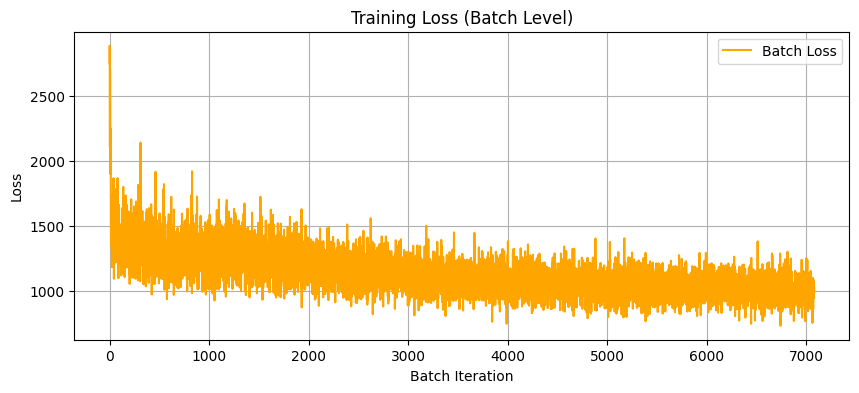

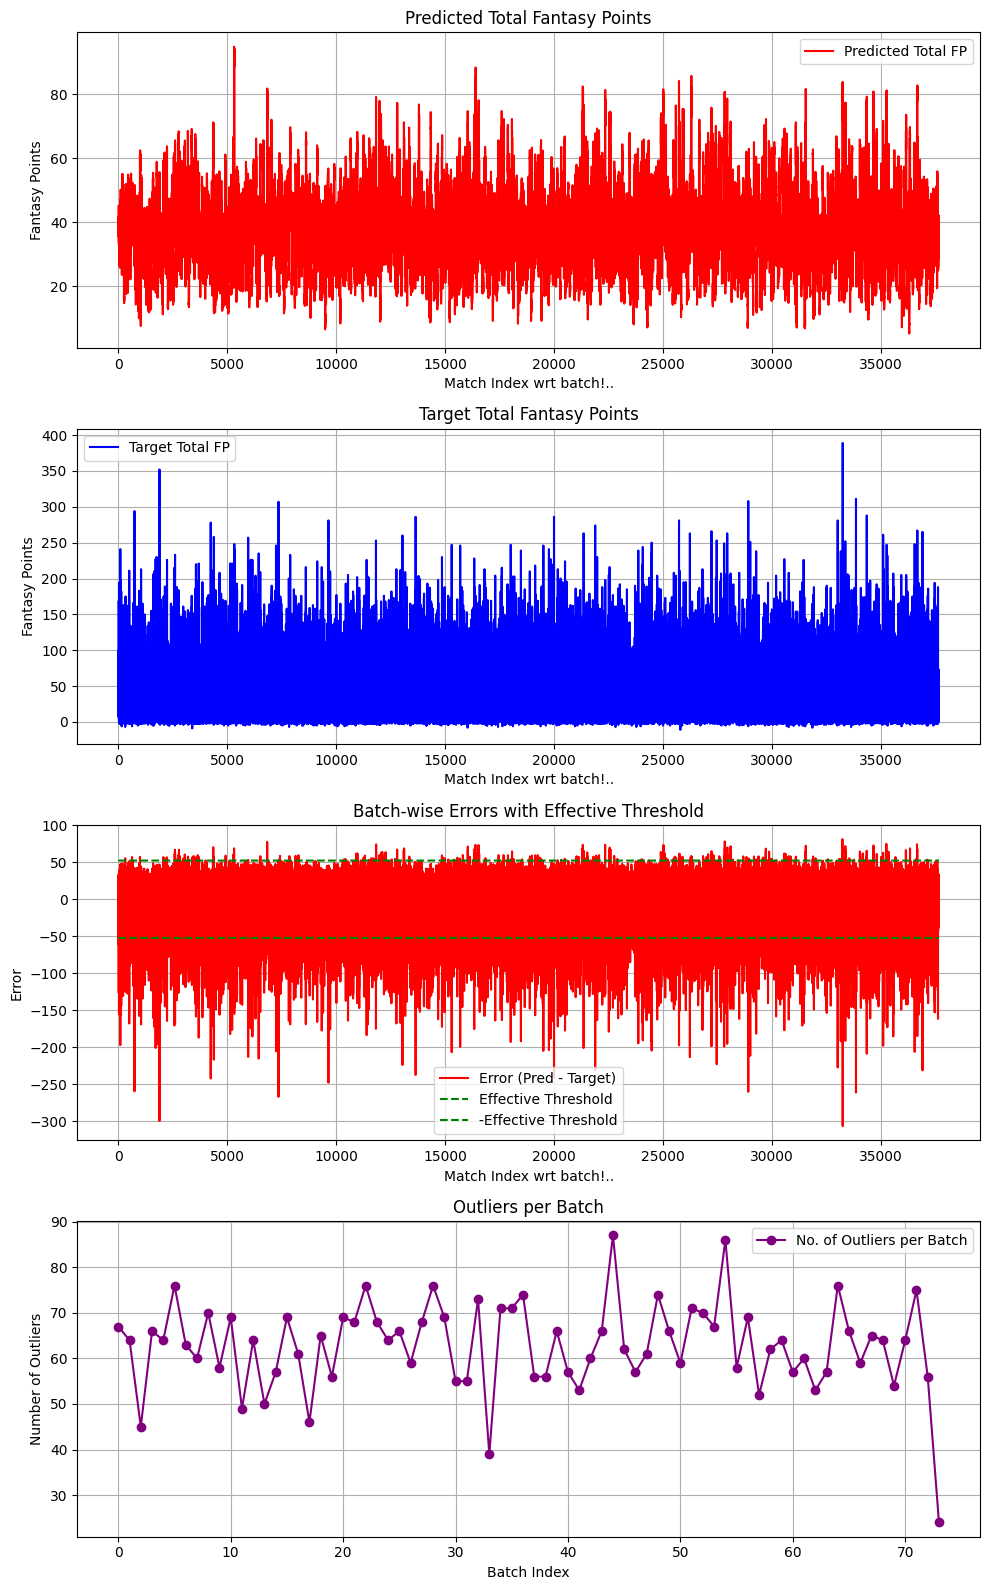

Epoch [1/100]: 100%|██████████| 74/74 [03:07<00:00,  2.53s/it, loss=1.33e+3]


Epoch 1/100 — Avg Loss: 1605.2937
Checkpoint saved at ipl_model_epoch_0_with_asymmetric_loss.pth


Epoch [2/100]: 100%|██████████| 74/74 [03:08<00:00,  2.54s/it, loss=1.36e+3]


Epoch 2/100 — Avg Loss: 1407.7807


Epoch [3/100]: 100%|██████████| 74/74 [03:01<00:00,  2.46s/it, loss=1.12e+3]


Epoch 3/100 — Avg Loss: 1385.5950


Epoch [4/100]: 100%|██████████| 74/74 [03:03<00:00,  2.48s/it, loss=1.31e+3]


Epoch 4/100 — Avg Loss: 1358.8871


Epoch [5/100]: 100%|██████████| 74/74 [03:03<00:00,  2.48s/it, loss=1.23e+3]


Epoch 5/100 — Avg Loss: 1342.0143


Epoch [6/100]: 100%|██████████| 74/74 [03:05<00:00,  2.50s/it, loss=1.06e+3]


Epoch 6/100 — Avg Loss: 1326.2789


Epoch [7/100]: 100%|██████████| 74/74 [03:03<00:00,  2.48s/it, loss=1.18e+3]


Epoch 7/100 — Avg Loss: 1312.6055


Epoch [8/100]: 100%|██████████| 74/74 [03:07<00:00,  2.53s/it, loss=1.37e+3]


Epoch 8/100 — Avg Loss: 1289.7858


Epoch [9/100]: 100%|██████████| 74/74 [03:07<00:00,  2.53s/it, loss=1.34e+3]


Epoch 9/100 — Avg Loss: 1289.7146


Epoch [10/100]: 100%|██████████| 74/74 [03:07<00:00,  2.53s/it, loss=1.5e+3] 


Epoch 10/100 — Avg Loss: 1273.7950


Epoch [11/100]: 100%|██████████| 74/74 [03:10<00:00,  2.58s/it, loss=1.34e+3]


Epoch 11/100 — Avg Loss: 1297.9477


Epoch [12/100]: 100%|██████████| 74/74 [03:10<00:00,  2.58s/it, loss=1.19e+3]


Epoch 12/100 — Avg Loss: 1295.0745


Epoch [13/100]: 100%|██████████| 74/74 [03:12<00:00,  2.60s/it, loss=1.53e+3]


Epoch 13/100 — Avg Loss: 1287.1167


Epoch [14/100]: 100%|██████████| 74/74 [03:12<00:00,  2.60s/it, loss=1.15e+3]


Epoch 14/100 — Avg Loss: 1273.9385


Epoch [15/100]: 100%|██████████| 74/74 [03:08<00:00,  2.55s/it, loss=1.2e+3] 


Epoch 15/100 — Avg Loss: 1272.7440


Epoch [16/100]: 100%|██████████| 74/74 [03:10<00:00,  2.57s/it, loss=1.3e+3] 


Epoch 16/100 — Avg Loss: 1294.5167


Epoch [17/100]: 100%|██████████| 74/74 [03:10<00:00,  2.58s/it, loss=1.24e+3]


Epoch 17/100 — Avg Loss: 1263.7206


Epoch [18/100]: 100%|██████████| 74/74 [03:14<00:00,  2.62s/it, loss=1.22e+3]


Epoch 18/100 — Avg Loss: 1255.6262


Epoch [19/100]: 100%|██████████| 74/74 [03:11<00:00,  2.58s/it, loss=1.15e+3]


Epoch 19/100 — Avg Loss: 1270.6199


Epoch [20/100]: 100%|██████████| 74/74 [03:11<00:00,  2.58s/it, loss=1.35e+3]
C:\Users\kumar\AppData\Local\Temp\ipykernel_23892\3321984477.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  outer_fig, (ax11,ax12,ax2,ax3) = plt.subplots(4,1,figsize=(10,16))


Epoch 20/100 — Avg Loss: 1262.9460


Epoch [21/100]: 100%|██████████| 74/74 [03:12<00:00,  2.60s/it, loss=1.14e+3]


Epoch 21/100 — Avg Loss: 1244.4107


Epoch [22/100]: 100%|██████████| 74/74 [03:13<00:00,  2.61s/it, loss=1.41e+3]


Epoch 22/100 — Avg Loss: 1257.2160


Epoch [23/100]: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it, loss=1.1e+3] 


Epoch 23/100 — Avg Loss: 1234.7694


Epoch [24/100]: 100%|██████████| 74/74 [03:12<00:00,  2.60s/it, loss=983]    


Epoch 24/100 — Avg Loss: 1221.9049


Epoch [25/100]: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it, loss=1.21e+3]


Epoch 25/100 — Avg Loss: 1236.5069


Epoch [26/100]: 100%|██████████| 74/74 [03:15<00:00,  2.64s/it, loss=1.03e+3]


Epoch 26/100 — Avg Loss: 1215.8314
Checkpoint saved at ipl_model_epoch_25_with_asymmetric_loss.pth


Epoch [27/100]: 100%|██████████| 74/74 [03:19<00:00,  2.70s/it, loss=1.13e+3]


Epoch 27/100 — Avg Loss: 1214.4918


Epoch [28/100]: 100%|██████████| 74/74 [03:16<00:00,  2.65s/it, loss=948]    


Epoch 28/100 — Avg Loss: 1174.4089


Epoch [29/100]: 100%|██████████| 74/74 [03:19<00:00,  2.69s/it, loss=953]    


Epoch 29/100 — Avg Loss: 1173.1120


Epoch [30/100]: 100%|██████████| 74/74 [03:14<00:00,  2.63s/it, loss=1.37e+3]


Epoch 30/100 — Avg Loss: 1168.7292


Epoch [31/100]: 100%|██████████| 74/74 [03:16<00:00,  2.65s/it, loss=1.4e+3] 


Epoch 31/100 — Avg Loss: 1169.9057


Epoch [32/100]: 100%|██████████| 74/74 [03:16<00:00,  2.65s/it, loss=1.34e+3]


Epoch 32/100 — Avg Loss: 1165.0402


Epoch [33/100]: 100%|██████████| 74/74 [03:15<00:00,  2.64s/it, loss=1.21e+3]


Epoch 33/100 — Avg Loss: 1153.7758


Epoch [34/100]: 100%|██████████| 74/74 [03:24<00:00,  2.77s/it, loss=1.17e+3]


Epoch 34/100 — Avg Loss: 1149.1392


Epoch [35/100]: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it, loss=897]    


Epoch 35/100 — Avg Loss: 1156.3385


Epoch [36/100]: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it, loss=913]    


Epoch 36/100 — Avg Loss: 1157.0592


Epoch [37/100]: 100%|██████████| 74/74 [03:20<00:00,  2.70s/it, loss=1.05e+3]


Epoch 37/100 — Avg Loss: 1150.0351


Epoch [38/100]: 100%|██████████| 74/74 [03:14<00:00,  2.63s/it, loss=1.05e+3]


Epoch 38/100 — Avg Loss: 1125.8930


Epoch [39/100]: 100%|██████████| 74/74 [03:17<00:00,  2.66s/it, loss=1.21e+3]


Epoch 39/100 — Avg Loss: 1130.7159


Epoch [40/100]: 100%|██████████| 74/74 [03:21<00:00,  2.73s/it, loss=1.06e+3]


Epoch 40/100 — Avg Loss: 1138.2971


Epoch [41/100]: 100%|██████████| 74/74 [03:20<00:00,  2.71s/it, loss=1.06e+3]


Epoch 41/100 — Avg Loss: 1114.1699


Epoch [42/100]: 100%|██████████| 74/74 [03:14<00:00,  2.63s/it, loss=1.04e+3]


Epoch 42/100 — Avg Loss: 1110.2310


Epoch [43/100]: 100%|██████████| 74/74 [03:26<00:00,  2.79s/it, loss=1.5e+3] 


Epoch 43/100 — Avg Loss: 1108.7717


Epoch [44/100]: 100%|██████████| 74/74 [03:20<00:00,  2.71s/it, loss=1.16e+3]


Epoch 44/100 — Avg Loss: 1105.3198


Epoch [45/100]: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it, loss=978]    


Epoch 45/100 — Avg Loss: 1109.0508


Epoch [46/100]: 100%|██████████| 74/74 [03:30<00:00,  2.84s/it, loss=1.26e+3]


Epoch 46/100 — Avg Loss: 1094.2584


Epoch [47/100]: 100%|██████████| 74/74 [03:30<00:00,  2.84s/it, loss=979]    


Epoch 47/100 — Avg Loss: 1099.1479


Epoch [48/100]: 100%|██████████| 74/74 [03:20<00:00,  2.70s/it, loss=852]    


Epoch 48/100 — Avg Loss: 1083.4818


Epoch [49/100]: 100%|██████████| 74/74 [03:23<00:00,  2.75s/it, loss=1.13e+3]


Epoch 49/100 — Avg Loss: 1091.8788


Epoch [50/100]: 100%|██████████| 74/74 [03:27<00:00,  2.81s/it, loss=944]    


Epoch 50/100 — Avg Loss: 1085.2174


Epoch [51/100]: 100%|██████████| 74/74 [03:24<00:00,  2.76s/it, loss=1.04e+3]


Epoch 51/100 — Avg Loss: 1077.5491
Checkpoint saved at ipl_model_epoch_50_with_asymmetric_loss.pth


Epoch [52/100]: 100%|██████████| 74/74 [03:23<00:00,  2.76s/it, loss=1.28e+3]


Epoch 52/100 — Avg Loss: 1091.0707


Epoch [53/100]: 100%|██████████| 74/74 [03:38<00:00,  2.96s/it, loss=845]    


Epoch 53/100 — Avg Loss: 1077.8558


Epoch [54/100]: 100%|██████████| 74/74 [03:35<00:00,  2.91s/it, loss=907]    


Epoch 54/100 — Avg Loss: 1067.2935


Epoch [55/100]: 100%|██████████| 74/74 [03:35<00:00,  2.91s/it, loss=1.18e+3]


Epoch 55/100 — Avg Loss: 1080.1791


Epoch [56/100]: 100%|██████████| 74/74 [03:33<00:00,  2.88s/it, loss=1.01e+3]


Epoch 56/100 — Avg Loss: 1065.0983


Epoch [57/100]: 100%|██████████| 74/74 [03:40<00:00,  2.98s/it, loss=1.12e+3]


Epoch 57/100 — Avg Loss: 1068.8515


Epoch [58/100]: 100%|██████████| 74/74 [03:39<00:00,  2.96s/it, loss=1.12e+3]


Epoch 58/100 — Avg Loss: 1072.9546


Epoch [59/100]: 100%|██████████| 74/74 [03:44<00:00,  3.04s/it, loss=1.22e+3]


Epoch 59/100 — Avg Loss: 1054.1129


Epoch [60/100]: 100%|██████████| 74/74 [03:41<00:00,  2.99s/it, loss=987]    


Epoch 60/100 — Avg Loss: 1052.4962


Epoch [61/100]: 100%|██████████| 74/74 [03:49<00:00,  3.10s/it, loss=1.05e+3]


Epoch 61/100 — Avg Loss: 1060.3443


Epoch [62/100]: 100%|██████████| 74/74 [03:43<00:00,  3.02s/it, loss=1.31e+3]


Epoch 62/100 — Avg Loss: 1054.7628


Epoch [63/100]: 100%|██████████| 74/74 [03:49<00:00,  3.10s/it, loss=1.05e+3]


Epoch 63/100 — Avg Loss: 1063.2279


Epoch [64/100]: 100%|██████████| 74/74 [03:45<00:00,  3.05s/it, loss=1.01e+3]


Epoch 64/100 — Avg Loss: 1034.8777


Epoch [65/100]: 100%|██████████| 74/74 [03:50<00:00,  3.12s/it, loss=1e+3]   


Epoch 65/100 — Avg Loss: 1040.9301


Epoch [66/100]: 100%|██████████| 74/74 [03:52<00:00,  3.14s/it, loss=1.17e+3]


Epoch 66/100 — Avg Loss: 1048.7150


Epoch [67/100]: 100%|██████████| 74/74 [03:51<00:00,  3.13s/it, loss=1.04e+3]


Epoch 67/100 — Avg Loss: 1031.7185


Epoch [68/100]: 100%|██████████| 74/74 [03:50<00:00,  3.12s/it, loss=848]    


Epoch 68/100 — Avg Loss: 1036.4483


Epoch [69/100]: 100%|██████████| 74/74 [03:52<00:00,  3.15s/it, loss=1.24e+3]


Epoch 69/100 — Avg Loss: 1044.6889


Epoch [70/100]: 100%|██████████| 74/74 [03:56<00:00,  3.19s/it, loss=1.05e+3]


Epoch 70/100 — Avg Loss: 1035.5760


Epoch [71/100]: 100%|██████████| 74/74 [03:54<00:00,  3.17s/it, loss=1.08e+3]


Epoch 71/100 — Avg Loss: 1037.2784


Epoch [72/100]: 100%|██████████| 74/74 [03:54<00:00,  3.17s/it, loss=1.13e+3]


Epoch 72/100 — Avg Loss: 1036.2227


Epoch [73/100]: 100%|██████████| 74/74 [03:59<00:00,  3.23s/it, loss=976]    


Epoch 73/100 — Avg Loss: 1037.4263


Epoch [74/100]: 100%|██████████| 74/74 [04:05<00:00,  3.32s/it, loss=1.11e+3]


Epoch 74/100 — Avg Loss: 1025.8475


Epoch [75/100]: 100%|██████████| 74/74 [04:11<00:00,  3.40s/it, loss=1.08e+3]


Epoch 75/100 — Avg Loss: 1032.7417


Epoch [76/100]: 100%|██████████| 74/74 [04:05<00:00,  3.32s/it, loss=1.2e+3] 


Epoch 76/100 — Avg Loss: 1025.2210
Checkpoint saved at ipl_model_epoch_75_with_asymmetric_loss.pth


Epoch [77/100]: 100%|██████████| 74/74 [04:08<00:00,  3.35s/it, loss=946]    


Epoch 77/100 — Avg Loss: 1025.4439


Epoch [78/100]: 100%|██████████| 74/74 [04:10<00:00,  3.38s/it, loss=913]    


Epoch 78/100 — Avg Loss: 1035.5916


Epoch [79/100]: 100%|██████████| 74/74 [04:02<00:00,  3.27s/it, loss=976]    


Epoch 79/100 — Avg Loss: 1029.6349


Epoch [80/100]: 100%|██████████| 74/74 [04:02<00:00,  3.27s/it, loss=1.03e+3]


Epoch 80/100 — Avg Loss: 1018.9460


Epoch [81/100]: 100%|██████████| 74/74 [03:56<00:00,  3.20s/it, loss=965]    


Epoch 81/100 — Avg Loss: 1030.0822


Epoch [82/100]: 100%|██████████| 74/74 [04:11<00:00,  3.40s/it, loss=893]    


Epoch 82/100 — Avg Loss: 1018.1144


Epoch [83/100]: 100%|██████████| 74/74 [04:04<00:00,  3.31s/it, loss=1.01e+3]


Epoch 83/100 — Avg Loss: 1025.2841


Epoch [84/100]: 100%|██████████| 74/74 [04:07<00:00,  3.34s/it, loss=958]    


Epoch 84/100 — Avg Loss: 1028.8838


Epoch [85/100]: 100%|██████████| 74/74 [04:12<00:00,  3.42s/it, loss=1.07e+3]


Epoch 85/100 — Avg Loss: 1022.4596


Epoch [86/100]: 100%|██████████| 74/74 [04:11<00:00,  3.40s/it, loss=1.15e+3]


Epoch 86/100 — Avg Loss: 1020.2651


Epoch [87/100]: 100%|██████████| 74/74 [04:14<00:00,  3.44s/it, loss=1.2e+3] 


Epoch 87/100 — Avg Loss: 1024.3018


Epoch [88/100]: 100%|██████████| 74/74 [04:22<00:00,  3.55s/it, loss=1.38e+3]


Epoch 88/100 — Avg Loss: 1024.4449


Epoch [89/100]: 100%|██████████| 74/74 [04:22<00:00,  3.54s/it, loss=1.02e+3]


Epoch 89/100 — Avg Loss: 1014.0633


Epoch [90/100]: 100%|██████████| 74/74 [04:24<00:00,  3.57s/it, loss=1.28e+3]


Epoch 90/100 — Avg Loss: 1017.1259


Epoch [91/100]: 100%|██████████| 74/74 [04:26<00:00,  3.60s/it, loss=1.06e+3]


Epoch 91/100 — Avg Loss: 1018.9776


Epoch [92/100]: 100%|██████████| 74/74 [04:19<00:00,  3.51s/it, loss=1.07e+3]


Epoch 92/100 — Avg Loss: 1013.1339


Epoch [93/100]: 100%|██████████| 74/74 [04:34<00:00,  3.71s/it, loss=1.02e+3]


Epoch 93/100 — Avg Loss: 1017.2120


Epoch [94/100]: 100%|██████████| 74/74 [04:41<00:00,  3.80s/it, loss=1.06e+3]


Epoch 94/100 — Avg Loss: 1007.9316


Epoch [95/100]: 100%|██████████| 74/74 [04:37<00:00,  3.76s/it, loss=939]    


Epoch 95/100 — Avg Loss: 1021.1242


Epoch [96/100]:  68%|██████▊   | 50/74 [03:23<01:37,  4.07s/it, loss=1.02e+3]


KeyboardInterrupt: 

In [ ]:
lossi = train(model, dataloader)


NameError: name 'model' is not defined

In [ ]:

checkpoint_path = f"ipl_model_epoch_{config.NUM_EPOCHS}_with_current_loss.pth"
torch.save({
'model_state_dict': model.state_dict(),
'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)
print(f"Checkpoint saved at {checkpoint_path}")

In [ ]:

# from tqdm import tqdm
# from typing import List
# import matplotlib.pyplot as plt
# from IPython.display import clear_output


# def train(model, dataloader, start_epoch=0,
#           decay_rate : float = 0.05, # decides how fast the threshold converges..
#     upper_threshold : float = 200,
#     min_threshold : float = 50,
#     ):
#     model.to(config.DEVICE)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
#     epoch_losses = []
#     losses = []
#     pred_total_fantasy_list = []      # cumulative predicted total fantasy points
#     target_total_fantasy_list = []    # cumulative target total fantasy points
#     error_list = []                   # cumulative error values (pred - target)
#     effective_threshold_list = []     # effective threshold replicated per match (for each batch)
#     no_outliers_per_batch = []        # number of outlier matches per batch

#     batch_counter = 0
#     for epoch in range(start_epoch, config.NUM_EPOCHS):
#         model.train()
#         total_loss = 0.0
#         effective_threshold = (upper_threshold - min_threshold) * math.exp(-decay_rate * epoch) + min_threshold

#         # Wrap dataloader with tqdm for progress bar
#         loop = tqdm(dataloader, leave=True)
#         loop.set_description(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]")
#         for batch in loop:
#             # Move tensors to device
#             for k, v in batch.items():
#                 if torch.is_tensor(v):
#                     batch[k] = v.to(config.DEVICE)

#             # Unpack batch
#             player_univ   = batch['univ_features']
#             context_feats = batch['context_matches']
#             team2_players = batch['team2_players']
#             match_info    = batch['match_info']
#             target_scores = batch['target_scores']
            
            
#             optimizer.zero_grad()
#             pred_fantasy = model(
#                 player_univ,
#                 context_feats,
#                 team2_players,
#                 match_info,
#                 target_scores
#             )
#             pred_total_fantasy = pred_fantasy.sum(dim = -1).reshape(-1) #(B*T,)
#             target_total_fantasy = target_scores.sum(dim =-1).reshape(-1) #(B*T,)
#             error = pred_total_fantasy - target_total_fantasy  # tensor shape: (B*T,)
#             abs_error_batch = (error.abs()) 
            
        
#             pred_total_fantasy_list.extend(pred_total_fantasy.to_list())
#             target_total_fantasy_list.extend(target_total_fantasy.to_list())
#             error_list.append(error.to_list())
#             effective_threshold_list.extend([effective_threshold] * error.shape[0])
            
#             #count outliers: matches where abs(error) > effective_threshold.
#             outlier_count = int(torch.sum((abs_error_batch > effective_threshold).to(torch.int)).item())
#             no_outliers_per_batch.append(outlier_count)
            
#             #Compute loss
#             loss = custom_loss(pred_fantasy, target_scores, epoch=epoch, 
#                                total_epoches=config.NUM_EPOCHS, min_threshold=min_threshold)
#             loss.backward()
#             optimizer.step()
            
#             loss_value = loss.item()
#             losses.append(loss_value)
#             total_loss += loss_value
#             batch_counter += 1
            
#             loop.set_postfix(loss=loss_value)     
#             # print("error_batch.shape: ")
#             # print(error_batch.shape)
              
#         clear_output(wait = True)
#         fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,12))
        
#         # Subplot 1: Cumulative predicted vs. target total fantasy points
#         ax1.plot(pred_total_fantasy_list, label='Predicted Total FP', color='red')
#         ax1.plot(target_total_fantasy_list, label='Target Total FP', color='blue')
#         ax1.set_xlabel('Match Index (Cumulative)')
#         ax1.set_ylabel('Fantasy Points')
#         ax1.set_title('Predicted vs. Target Total Fantasy Points')
#         ax1.grid(True)
#         ax1.legend()
        
#         # Subplot 2: Cumulative error with effective threshold lines
#         ax2.plot(error_list, label='Error (Pred - Target)', color='red')
#         # Plot the effective threshold (and its negative) as horizontal lines
#         ax2.plot(effective_threshold_list, label='Effective Threshold', color='green', linestyle='--')
#         ax2.plot([-thr for thr in effective_threshold_list], label='-Effective Threshold', color='green', linestyle='--')
#         ax2.set_xlabel('Match Index (Cumulative)')
#         ax2.set_ylabel('Error')
#         ax2.set_title('Batch-wise Errors with Effective Threshold')
#         ax2.grid(True)
#         ax2.legend()
        
#         # Subplot 3: Outliers per batch
#         # Create an x-axis for batches (1-indexed)
#         ax3.plot(range(1, len(no_outliers_per_batch)+1), no_outliers_per_batch, marker='o',
#                     label='No. of Outliers per Batch', color='purple')
#         ax3.set_xlabel('Batch Index')
#         ax3.set_ylabel('Number of Outliers')
#         ax3.set_title('Outliers per Batch')
#         ax3.grid(True)
#         ax3.legend()
        
#         plt.tight_layout()
#         plt.show()
        
#         avg_loss = total_loss / len(dataloader)
#         epoch_losses.append(avg_loss)  
    
#         print(f"Epoch {epoch+1}/{config.NUM_EPOCHS} — Avg Loss: {avg_loss:.4f}")
#         if (epoch - start_epoch) % 50 == 0:
#             checkpoint_path = f"ipl_model_epoch_{epoch}_with_asymmetric_loss.pth"
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#             }, checkpoint_path)
#             print(f"Checkpoint saved at {checkpoint_path}")
#     return epoch_losses,losses
